## Parallelize Pandas with Dask.dataframe


In [5]:
import dask
from dask.distributed import Client, progress
from dask import delayed
df = None
c = Client('tcp://localhost:8786')
c.restart()
c

Client Scheduler: tcp://localhost:8786 Dashboard: http://localhost:8787/status,Cluster Workers: 10 Cores: 40 Memory: 294.81 GB


In [6]:
# enable this code path if you have download the nyctaxi data to 
# the workspace's default blob store (needs to be in the folder nyctaxi)
if False:
    ## or load directly through blob file system
    # using https://github.com/dask/adlfs -- still pretty beta, 
    # throws an error message, but seesm to work
    from azureml.core import Workspace
    ws = Workspace.from_config()
    ds = ws.get_default_datastore()
    ACCOUNT_NAME = ds.account_name
    ACCOUNT_KEY = ds.account_key
    CONTAINER = ds.container_name
    import dask.dataframe as dd
    from fsspec.registry import known_implementations
    known_implementations['abfs'] = {'class': 'adlfs.AzureBlobFileSystem'}
    STORAGE_OPTIONS={'account_name': ACCOUNT_NAME, 'account_key': ACCOUNT_KEY}
    df = dd.read_csv(f'abfs://{CONTAINER}/nyctaxi/2015/*.csv', 
                     storage_options=STORAGE_OPTIONS,
                     parse_dates=['tpep_pickup_datetime', 'tpep_dropoff_datetime'])

In [7]:
# enable this code path instead of the above if you run into
# any issues with the AzureBlobFileSystem (https://github.com/dask/adlfs)
# this will load the data from the workspace blob storage mounted via blobFUSE
if False:
    from azureml.core import Workspace
    ## get the last run on the dask experiment which should be running 
    ## our dask cluster, and retrieve the data path from it
    ws = Workspace.from_config()
    exp = ws.experiments['dask']
    run = None
    for run in ws.experiments['dask'].get_runs():
        if run.get_status() == "Running":
            cluster_run = run
            break;

    if (run == None):
        raise Exception('Cluster should be in state \'Running\'')

    data_path = cluster_run.get_metrics()['datastore'] + '/nyctaxi'


    import dask
    import dask.dataframe as dd
    from dask import delayed

    def load_data(path):
        return dd.read_csv(path, parse_dates=['tpep_pickup_datetime', 'tpep_dropoff_datetime'])

    data_2015 = data_path + '/2015'
    data_2015_csv = data_2015 + '/*.csv'
    df = delayed(load_data)(data_2015_csv).compute()

In [8]:
# fall back to this path if neither of the above paths have been enabled
if df is None:
    ## or in this case straight from GOOGLE Storage
    import dask.dataframe as dd
    df = dd.read_csv('gcs://anaconda-public-data/nyc-taxi/csv/2015/yellow_*.csv',
                     storage_options={'token': 'anon'}, 
                     parse_dates=['tpep_pickup_datetime', 'tpep_dropoff_datetime'])


In [9]:
%time len(df)

CPU times: user 1.34 s, sys: 85.5 ms, total: 1.42 s
Wall time: 1min 6s


146112989

In [234]:
df.partitions

In [226]:
%time df.map_partitions(len).compute().sum()

CPU times: user 1.38 s, sys: 53.5 ms, total: 1.44 s
Wall time: 46.8 s


146112989


Dask DataFrames
---------------

*  Coordinate many Pandas DataFrames across a cluster
*  Faithfully implement a subset of the Pandas API
*  Use Pandas under the hood (for speed and maturity)

In [207]:
df

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RateCodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
npartitions=365,,,,,,,,,,,,,,,,,,,
,int64,datetime64[ns],datetime64[ns],int64,float64,float64,float64,int64,object,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [208]:
df.dtypes

VendorID                          int64
tpep_pickup_datetime     datetime64[ns]
tpep_dropoff_datetime    datetime64[ns]
passenger_count                   int64
trip_distance                   float64
pickup_longitude                float64
pickup_latitude                 float64
RateCodeID                        int64
store_and_fwd_flag               object
dropoff_longitude               float64
dropoff_latitude                float64
payment_type                      int64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
improvement_surcharge           float64
total_amount                    float64
dtype: object

In [209]:
# list of column names that need to be re-mapped
remap = {}
remap['tpep_pickup_datetime'] = 'pickup_datetime'
remap['tpep_dropoff_datetime'] = 'dropoff_datetime'
remap['RatecodeID'] = 'rate_code'

#create a list of columns & dtypes the df must have
must_haves = {
    'VendorID': 'object',
    'pickup_datetime': 'datetime64[ms]',
    'dropoff_datetime': 'datetime64[ms]',
    'passenger_count': 'int32',
    'trip_distance': 'float32',
    'pickup_longitude': 'float32',
    'pickup_latitude': 'float32',
    'rate_code': 'int32',
    'payment_type': 'int32',
    'dropoff_longitude': 'float32',
    'dropoff_latitude': 'float32',
    'fare_amount': 'float32',
    'tip_amount': 'float32',
    'total_amount': 'float32'
}

query_frags = [
    'fare_amount > 0 and fare_amount < 500',
    'passenger_count > 0 and passenger_count < 6',
    'pickup_longitude > -75 and pickup_longitude < -73',
    'dropoff_longitude > -75 and dropoff_longitude < -73',
    'pickup_latitude > 40 and pickup_latitude < 42',
    'dropoff_latitude > 40 and dropoff_latitude < 42'
]
query = ' and '.join(query_frags)

In [210]:
# helper function which takes a DataFrame partition
def clean(df_part, remap, must_haves, query):    
    df_part = df_part.query(query)
    
    # some col-names include pre-pended spaces remove & lowercase column names
    # tmp = {col:col.strip().lower() for col in list(df_part.columns)}

    # rename using the supplied mapping
    df_part = df_part.rename(columns=remap)
    
    # iterate through columns in this df partition
    for col in df_part.columns:
        # drop anything not in our expected list
        if col not in must_haves:
            df_part = df_part.drop(col, axis=1)
            continue

        if df_part[col].dtype == 'object' and col in ['pickup_datetime', 'dropoff_datetime']:
            df_part[col] = df_part[col].astype('datetime64[ms]')
            continue
            
        # if column was read as a string, recast as float
        if df_part[col].dtype == 'object':
            df_part[col] = df_part[col].str.fillna('-1')
            df_part[col] = df_part[col].astype('float32')
        else:
            # save some memory by using 32 bit floats
            if 'int' in str(df_part[col].dtype):
                df_part[col] = df_part[col].astype('int32')
            if 'float' in str(df_part[col].dtype):
                df_part[col] = df_part[col].astype('float32')
            df_part[col] = df_part[col].fillna(-1)
    
    return df_part

In [211]:
taxi_df = clean(df, remap, must_haves, query)

In [212]:
import math
from math import  pi
from dask.array import cos, sin, arcsin, sqrt, floor
import numpy as np

def haversine_distance(pickup_latitude, pickup_longitude, dropoff_latitude, dropoff_longitude):
    x_1 = pi / 180 * pickup_latitude
    y_1 = pi / 180 * pickup_longitude
    x_2 = pi / 180 * dropoff_latitude
    y_2 = pi / 180 * dropoff_longitude

    dlon = y_2 - y_1
    dlat = x_2 - x_1
    a = sin(dlat / 2)**2 + cos(x_1) * cos(x_2) * sin(dlon / 2)**2

    c = 2 * arcsin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers

    return c * r

def day_of_the_week(day, month, year):
    if month < 3:
        shift = month
    else:
        shift = 0
    Y = year - (month < 3)
    y = Y - 2000
    c = 20
    d = day
    m = month + shift + 1
    return (d + floor(m * 2.6) + y + (y // 4) + (c // 4) - 2 * c) % 7
        
def add_features(df):
    df['hour'] = df['pickup_datetime'].dt.hour.astype('int32')
    df['year'] = df['pickup_datetime'].dt.year.astype('int32')
    df['month'] = df['pickup_datetime'].dt.month.astype('int32')
    df['day'] = df['pickup_datetime'].dt.day.astype('int32')
    df['day_of_week'] = df['pickup_datetime'].dt.weekday.astype('int32')
       
    #df['diff'] = df['dropoff_datetime'].astype('int32') - df['pickup_datetime'].astype('int32')
    df['diff'] = df['dropoff_datetime'] - df['pickup_datetime']
    
    df['pickup_latitude_r'] = (df['pickup_latitude'] // .01 * .01).astype('float32')
    df['pickup_longitude_r'] = (df['pickup_longitude'] // .01 * .01).astype('float32')
    df['dropoff_latitude_r'] = (df['dropoff_latitude'] // .01 * .01).astype('float32')
    df['dropoff_longitude_r'] = (df['dropoff_longitude'] // .01 * .01).astype('float32')
    
    #df = df.drop('pickup_datetime', axis=1)
    #df = df.drop('dropoff_datetime', axis=1)

    #df = df.apply_rows(haversine_distance_kernel,
    #                   incols=['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude'],
    #                   outcols=dict(h_distance=np.float32),
    #                   kwargs=dict())

    import numpy

    df['h_distance'] = haversine_distance(df['pickup_latitude'], 
                                          df['pickup_longitude'], 
                                          df['dropoff_latitude'], 
                                          df['dropoff_longitude']).astype('float32')

    #df = df.apply_rows(day_of_the_week_kernel,
    #                   incols=['day', 'month', 'year'],
    #                   outcols=dict(day_of_week=np.float32),
    #                   kwargs=dict())
    #df['day_of_week'] = numpy.empty(len(df), dtype=np.int32)
    #day_of_the_week_kernel(df['day'],
    #                       df['month'],
    #                       df['year'],
    #                       df['day_of_week'])
    
    
    df['is_weekend'] = (df['day_of_week']>5).astype("int32")
    return df

In [213]:
taxi_df = add_features(taxi_df)
taxi_df.dtypes

VendorID                         int32
pickup_datetime         datetime64[ns]
dropoff_datetime        datetime64[ns]
passenger_count                  int32
trip_distance                  float32
pickup_longitude               float32
pickup_latitude                float32
dropoff_longitude              float32
dropoff_latitude               float32
payment_type                     int32
fare_amount                    float32
tip_amount                     float32
total_amount                   float32
hour                             int32
year                             int32
month                            int32
day                              int32
day_of_week                      int32
diff                   timedelta64[ns]
pickup_latitude_r              float32
pickup_longitude_r             float32
dropoff_latitude_r             float32
dropoff_longitude_r            float32
h_distance                     float32
is_weekend                       int32
dtype: object

In [214]:
taxi_df = taxi_df.persist()
progress(taxi_df)

VBox()

In [215]:
%time len(taxi_df)

CPU times: user 70.9 ms, sys: 8.02 ms, total: 78.9 ms
Wall time: 261 ms


138367618

In [135]:
%time taxi_df.passenger_count.sum().compute()

CPU times: user 329 ms, sys: 48.4 ms, total: 377 ms
Wall time: 587 ms


211217394

In [136]:
# Compute average trip distance grouped by passenger count
taxi_df.groupby('passenger_count').trip_distance.mean().compute()

passenger_count
1    13.286467
2    11.615821
3     8.242469
4     7.561756
5     3.073684
Name: trip_distance, dtype: float64

### Tip Fraction, grouped by day-of-week and hour-of-day

In [137]:
df2 = taxi_df[(taxi_df.tip_amount > 0) & (taxi_df.fare_amount > 0)]
df2['tip_fraction'] = df2.tip_amount / df2.fare_amount

In [138]:
# Group df.tpep_pickup_datetime by dayofweek and hour
dayofweek = df2.groupby(df2.pickup_datetime.dt.dayofweek).tip_fraction.mean() 
hour = df2.groupby(df2.pickup_datetime.dt.hour).tip_fraction.mean()

dayofweek, hour = dask.persist(dayofweek, hour)
progress(dayofweek, hour)

VBox()

### Plot results

This requires matplotlib to be installed

In [139]:
%matplotlib inline

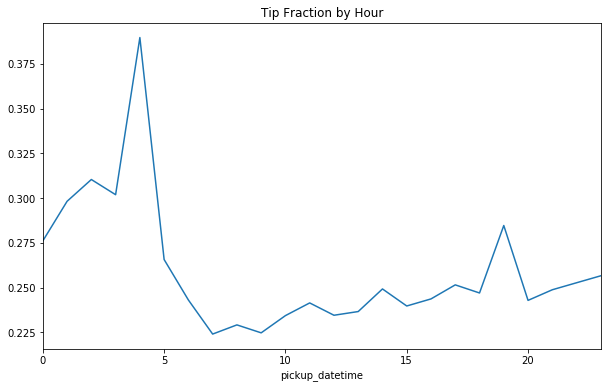

In [140]:
hour.compute().plot(figsize=(10, 6), title='Tip Fraction by Hour')

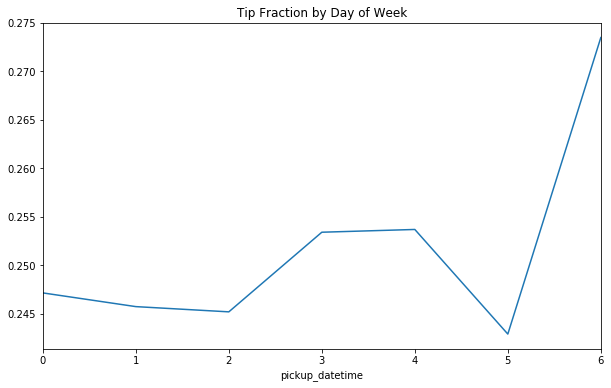

In [141]:
dayofweek.compute().plot(figsize=(10, 6), title='Tip Fraction by Day of Week')

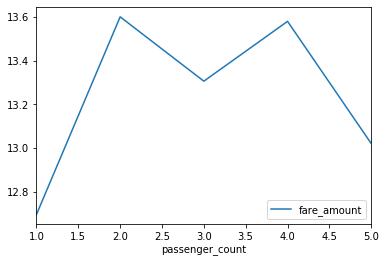

In [142]:
import pandas as pd
%matplotlib inline
taxi_df.groupby('passenger_count').fare_amount.mean().compute().sort_index().plot(legend=True)

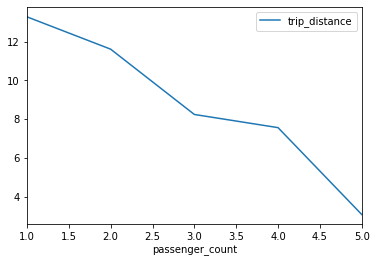

In [143]:
taxi_df.groupby(taxi_df.passenger_count).trip_distance.mean().compute().plot(legend=True)

In [181]:
by_payment = taxi_df.groupby(taxi_df.payment_type).fare_amount.count().compute()
by_payment.index = by_payment.index.map({1: 'Credit card',
    2: 'Cash',
    3: 'No charge',
    4: 'Dispute',
    5: 'Unknown',
    6: 'Voided trip'})

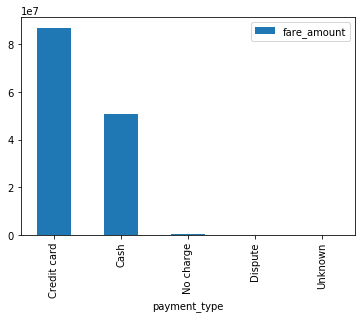

In [182]:
by_payment.plot(legend=True, kind='bar')
